In [1]:
import math 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib_inline 
import csv

class value:

    def __init__(self,data,_children=(),_op="",label =""):
        self.data= data
        self.prev = set(_children)
        self._op =_op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None
        
    
    def __repr__(self):
        return f"value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, value) else value(other)
        out = value(self.data + other.data,(self,other),"+")

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other)
        out = value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self,other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1

    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self,other):
        assert isinstance(other,(int,float)), "only supporting float right now"
        out = value(self.data**other, (self,), f"**{other}")

        def _backward():
            self.grad += other*(self.data** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self * other**-1

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = value(t,(self,), "tanh")
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def sigmoid(self):
        x = self.data
        s = 1/(1+math.exp(-x))
        out = (value(s,(self,), "sigmoid"))
        def _backward():
            self.grad += s * (1-s)*out.grad
        out._backward = _backward
        return out
    
    def relu(self):
        x = self.data
        r = max(0,x)
        out = (value(r,(self,), "relu"))
        def _backward():
            self.grad += out.grad * (1 if self.data > 0 else 0)
        out._backward = _backward
        return out

    
    def exp(self):
        x = self.data
        out = value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        return out
    
    
    def backward(self):
        list = []
        visited = set()
        def topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.prev:
                    topo(child)
                list.append(v)
        topo(self)
        self.grad = 1.0
        for node in reversed(list):
            node._backward()

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label="o"


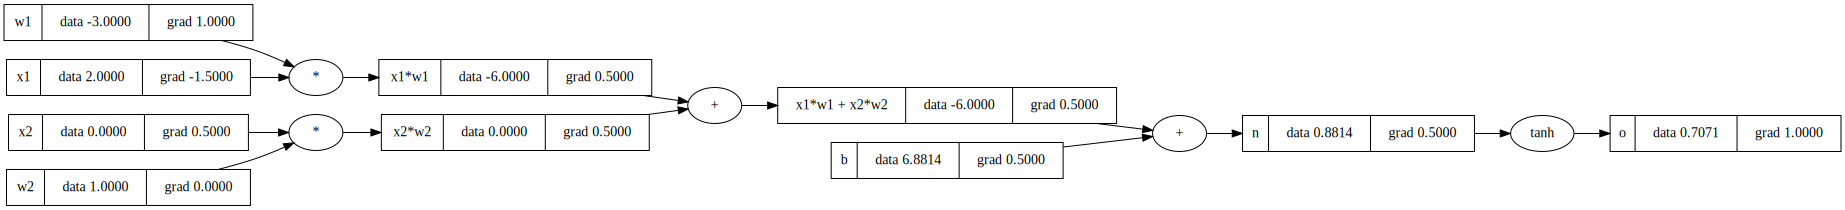

In [4]:
o.backward()
draw_dot(o)

In [5]:
a = value(2.0)
b = value(3.0)

c = a -b
c.data

-1.0

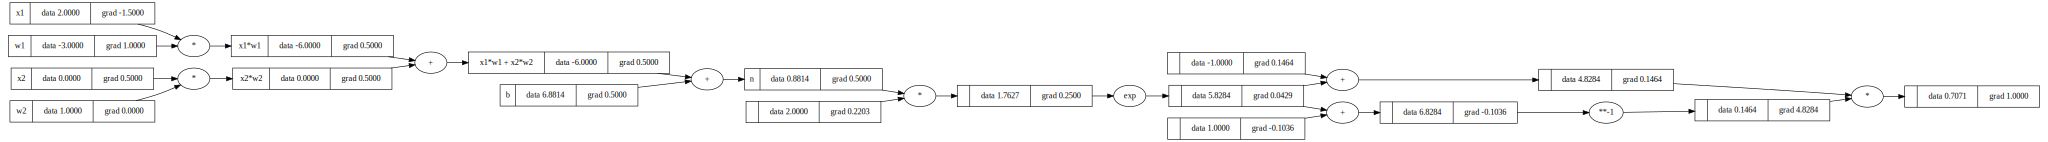

In [6]:


x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e - 1) / (e + 1)
o = o; label="o"
o.backward()
draw_dot(o)
        


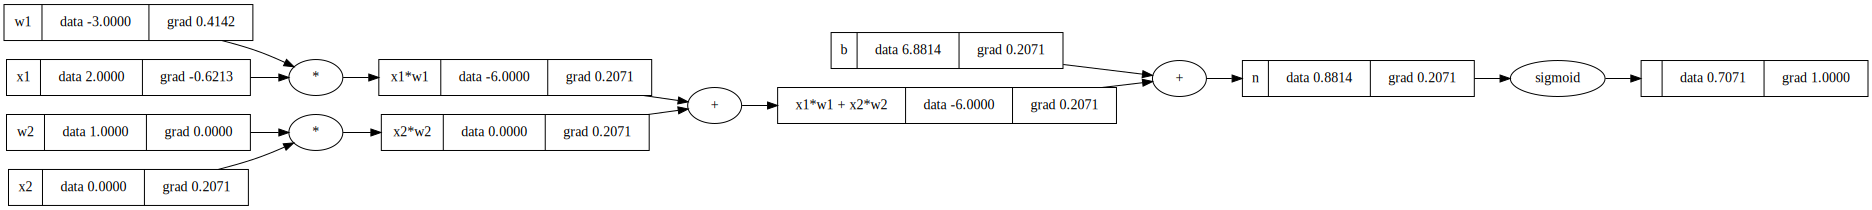

In [9]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
s = n.sigmoid(); o.label="sigmoid"
s.backward()
draw_dot(s)

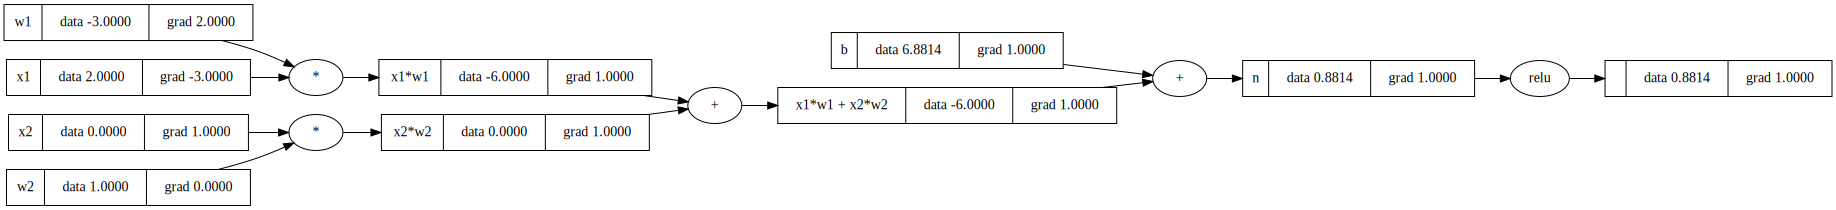

In [8]:
# inputs x1,x2
x1 = value(2.0, label='x1')
x2 = value(0.0, label='x2')
# weights w1,w2
w1 = value(-3.0, label='w1')
w2 = value(1.0, label='w2')
# bias of the neuron
b = value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
s = n.relu(); o.label="relu"
s.backward()
draw_dot(s)